In [ ]:
#Installation of segmentation models and tools for saving of the learned models
!pip install git+https://github.com/qubvel/segmentation_models
!pip install h5py
!pip install imantics

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8q2zu4vx
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8q2zu4vx
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=1ea6990e90ca5b8564e20c691ac73513e671a90d01050fb605be35c0e1b991a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7aihaum/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Created wheel for imantics: filename=imantics-0.1.12-cp36-none-any.whl size=16034 sha256=dd74f7042b111eab5b5ef889a5804293c117cdd6bc78559d4008aa9220dda8b5
  Stored in directory: /root/.cache/pip/wheels/73/93/1c/9e2fc52eb74441941bc76cac441ddcc2c7ad67b18e1849e62a
Successfully built imantics


In [ ]:
#Importing tools that are neccessary to extract markup data, construct and evaluate the model, preprocess the dataset and plot the results
%tensorflow_version 1.x
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import utils
import keras_preprocessing.image.utils as image_utils
from keras.models import model_from_json
from PIL import Image
from imantics import Mask
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import skimage.io
import keras
import glob
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2

TensorFlow 1.x selected.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def getTrainingData(groups):
  '''
  This function is used to make a segmentation masks for train part of dataset.
  '''

    # Define path
  annFile = "src/Screen segmentation/JSONs/train.json"

    # Initialize COCO ground truth API
  cocoGt = COCO(annFile)

  categories = cocoGt.loadCats(cocoGt.getCatIds())
  categoryNames = [cat['name'] for cat in categories]
  print('COCO Stuff leaf categories: \n', ' '.join(categoryNames))

  superCategoryNames = sorted(set([cat['supercategory'] for cat in categories]))
  print ('COCO Stuff super categories: \n', ' '.join(superCategoryNames))
  images = []
  masks = []
  WORKDIR = "src/Screen segmentation"

    
  imgIds = cocoGt.getImgIds()
  I = 0
  for imgId in imgIds:
    img = cocoGt.loadImgs(imgId)[0]

    
    if (WORKDIR + "/datasets/train/images/imgs/"+ img['file_name']) in glob.glob(WORKDIR + "/datasets/train/images/imgs/*.png"):
      I = cv2.imread(WORKDIR + "/datasets/train/images/imgs/" + img['file_name'])
    else:
      I = cv2.imread(WORKDIR + "/datasets/test/images/imgs/" + img['file_name'])
    gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Load and display stuff annotations
    annIds = cocoGt.getAnnIds(imgIds=img['id'])
    anns = cocoGt.loadAnns(annIds)
    mask = np.zeros((768, 1366))
    for ann in anns:
      name = ann['metadata']['name']
      klass = groups[name]
      ind = groups[name] - 1
      x_start = ann['bbox'][0]
      x_end = x_start + ann['bbox'][2]
      y_start = ann['bbox'][1]
      y_end = y_start + ann['bbox'][3]
      mask = np.maximum(mask, cocoGt.annToMask(ann) * klass).astype('uint8')
      
    for i in range(len(mask)):
      for j in range(len(mask[i])):
        if mask[i][j] == 0:
          mask[i][j] = 5

    #This code is used to save images and masks. Because we already have images and masks, this cod is inactive.
    
    #if (WORKDIR + "/datasets/train/images/imgs/"+ img['file_name']) in glob.glob(WORKDIR + "/datasets/train/images/imgs/*.png"):
      #cv2.imwrite(WORKDIR + "/datasets/train/masks/msks2/" + img['file_name'], mask)
    #else:
      #cv2.imwrite(WORKDIR + "/datasets/test/masks/msks2/" + img['file_name'], mask)
        
    masks.append(mask)
    images.append(I)
  return np.asarray(images), np.asarray(masks)

def getValidationData(groups):
  '''
  This function is used to make a segmentation masks for validation part of dataset.
  '''
  ii = 1
  annFile = "src/Screen segmentation/JSONs/valid.json"

    # Initialize COCO ground truth API
  cocoGt = COCO(annFile)
  images = []
  masks = []

    # Load info for a random image
  WORKDIR = "src/Screen segmentation"
  imgIds = cocoGt.getImgIds()
  for imgId in imgIds:
    img = cocoGt.loadImgs(imgId)[0]

    # Load and display image
    I = cv2.imread("src/Screen segmentation/datasets/validation/images/imgs/" + img['file_name'])
    ii+=1

    # Load and display stuff annotations
    annIds = cocoGt.getAnnIds(imgIds=img['id'])
    anns = cocoGt.loadAnns(annIds)
    mask = np.zeros((768, 1366))
    for ann in anns:
      name = ann['metadata']['name']
      klass = groups[name]
      ind = groups[name] - 1
      x_start = ann['bbox'][0]
      x_end = x_start + ann['bbox'][2]
      y_start = ann['bbox'][1]
      y_end = y_start + ann['bbox'][3]
      mask = np.maximum(mask, cocoGt.annToMask(ann) * klass).astype('uint8')
    for i in range(len(mask)):
      for j in range(len(mask[i])):
        if mask[i][j] == 0:
          mask[i][j] = 5
    
    #This code is used to save images and masks. Because we already have images and masks, this cod is inactive.
    
    #cv2.imwrite(WORKDIR + "/datasets/validation/masks/msks2/" + img['file_name'], mask)
    
    masks.append(mask)
    images.append(I)
  return np.asarray(images), np.asarray(masks)

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def transform_mask(mask):
    mask = mask.squeeze()
    mask_layers = [(mask == klass) for klass in groups.values()]
    layered_mask = np.stack(mask_layers, axis=-1).astype('float')
    return layered_mask

In [ ]:
WORKDIR = "src/Screen segmentation"
groups = {'team_score1': 1, 'team_score2': 2, 'team_stat1' : 3, 'team_stat2' : 4, 'undefined' : 5}
#X, Y = getTrainingData(groups)


loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
COCO Stuff leaf categories: 
 games
COCO Stuff super categories: 
 
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [ ]:
#Preparation of validation data

valid_images, valid_masks = getValidationData(groups)
v_masks = []
for mask in valid_masks:
  v_masks.append(transform_mask(mask))

v_images = []
for i in range(len(valid_images)):
  v_images.append(cv2.resize(valid_images[i], (256, 256)))

v_images = np.asarray(v_images)

vv_masks = []
for i in range(len(v_masks)):
  vv_masks.append(cv2.resize(v_masks[i], (256, 256)))

vv_masks = np.asarray(vv_masks)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [ ]:
#Preparation of image generators for augmentation 

SEED = 0
TARGET_SIZE = (256, 256)
BACKBONE = 'resnet34'
BATCH_SIZE = 5
TRESHOLD = 0.7
preprocess_input = sm.get_preprocessing(BACKBONE)

data_gen_args = dict(rotation_range=10,
    shear_range=0.05,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05)

train_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, **data_gen_args)
train_mask_datagen = ImageDataGenerator(preprocessing_function = transform_mask, **data_gen_args)

train_image_generator = train_image_datagen.flow_from_directory(WORKDIR + '/datasets/train/images',
target_size = TARGET_SIZE, class_mode = None, batch_size = BATCH_SIZE, seed=SEED)
train_mask_generator = train_mask_datagen.flow_from_directory(WORKDIR + '/datasets/train/masks',
target_size = TARGET_SIZE, class_mode = None, batch_size = BATCH_SIZE, color_mode='grayscale', seed=SEED)

train_mask_generator.image_shape = train_mask_generator.target_size + (len(groups), )

test_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_mask_datagen = ImageDataGenerator(preprocessing_function = transform_mask)

test_image_generator = test_image_datagen.flow_from_directory(WORKDIR + '/datasets/test/images',
target_size = TARGET_SIZE, class_mode = None, batch_size = BATCH_SIZE, seed=SEED)
test_mask_generator = test_mask_datagen.flow_from_directory(WORKDIR + '/datasets/test/masks',
target_size = TARGET_SIZE, class_mode = None, batch_size = BATCH_SIZE, color_mode='grayscale', seed=SEED)

test_mask_generator.image_shape = test_mask_generator.target_size + (len(groups), )

train_generator = zip(train_image_generator, train_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [ ]:
#Loading of train and test sets

x_train = []
x_test = []
y_train = []
y_test = []
for filename in glob.glob(WORKDIR + '/datasets/train/images/imgs/*.png'):
    im=image_utils.load_img(filename)
    im=image_utils.img_to_array(im)
    x_train.append(im)

for filename in glob.glob(WORKDIR + '/datasets/test/images/imgs/*.png'):
    im=image_utils.load_img(filename)
    im=image_utils.img_to_array(im)
    x_test.append(im)

for filename in glob.glob(WORKDIR + '/datasets/train/masks/msks2/*.png'):
    im=image_utils.load_img(filename)
    im=image_utils.img_to_array(im)
    im=transform_mask(im[...,0])
    y_train.append(im)

for filename in glob.glob(WORKDIR + '/datasets/test/masks/msks2/*.png'):
    im=image_utils.load_img(filename)
    im=image_utils.img_to_array(im)
    im=transform_mask(im[...,0])
    y_test.append(im)
    

In [ ]:
#Image generation and visualisation

counter = 2
for (img_batch, mask_batch) in test_generator:
    if not counter:
        break

    for (img, mask) in zip(img_batch, mask_batch):
        visualize(
            image=denormalize(img.squeeze()),
            score_mask=mask[..., 0],
            score2_mask=mask[..., 1],
            stats1_mask=mask[..., 2],
            stats2_mask=mask[..., 3],
            background=mask[..., 4],
        )

    counter -= 1

In [ ]:
#Initializing and compiling the model

n_classes = len(groups)
activation = 'sigmoid'
LR = 0.0007

WORKDIR = "src/Screen segmentation"
BACKBONE = 'resnet34'
BATCH_SIZE = 5
EPOCHS = 60
TRESHOLD = 0.7

# define model
model = sm.Unet(
    BACKBONE,
    classes=n_classes,
    activation=activation,
    encoder_weights='imagenet')
model.compile(
    keras.optimizers.Adam(LR),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score])

In [ ]:
callbacks = [keras.callbacks.ReduceLROnPlateau()]

#Model learning

history = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(40 / BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(10 / BATCH_SIZE),
    callbacks=callbacks)

Epoch 1/60
8/8 [==============================] - 43s 5s/step - loss: 1.5709 - iou_score: 0.1489 - val_loss: 4.3781 - val_iou_score: 0.0419
Epoch 2/60
8/8 [==============================] - 36s 5s/step - loss: 1.3599 - iou_score: 0.1846 - val_loss: 9.8374 - val_iou_score: 0.0320
Epoch 3/60
8/8 [==============================] - 37s 5s/step - loss: 1.2120 - iou_score: 0.2204 - val_loss: 16.5725 - val_iou_score: 0.0378
Epoch 4/60
8/8 [==============================] - 37s 5s/step - loss: 1.0883 - iou_score: 0.2515 - val_loss: 16.6427 - val_iou_score: 0.0349
Epoch 5/60
8/8 [==============================] - 36s 5s/step - loss: 0.9795 - iou_score: 0.2848 - val_loss: 10.1178 - val_iou_score: 0.0407
Epoch 6/60
8/8 [==============================] - 36s 5s/step - loss: 0.8874 - iou_score: 0.3195 - val_loss: 7.0300 - val_iou_score: 0.0638
Epoch 7/60
8/8 [==============================] - 36s 5s/step - loss: 0.8091 - iou_score: 0.3542 - val_loss: 3.0197 - val_iou_score: 0.0964
Epoch 8/60
8/8 [=

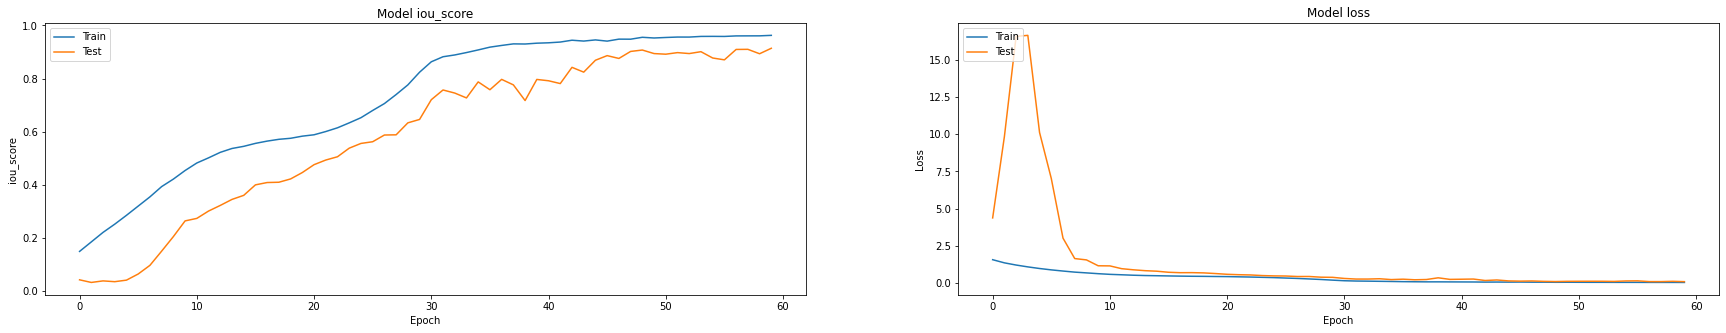

In [ ]:
# Plot training & validation loss values

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Model loading

LR = 0.0007
json_file = open(WORKDIR +"/model/" + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(WORKDIR +"/model/" + "model.h5")
loaded_model.compile(keras.optimizers.Adam(LR),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#Making predictions

preds = loaded_model.predict(v_images)
results = []
for i in range(len(vv_masks)):
  result = loaded_model.evaluate(np.expand_dims(v_images[i], axis=0), np.expand_dims(vv_masks[i], axis=0))
  result.append(i)
  results.append(result)

results = sorted(results, key = lambda x: x[1])
ind = [x[2] for x in results]

1/1 [==============================] - 0s 235ms/step


TOP-5 Best and TOP-5 Worst results in validation datset:


TOP-5 Best:


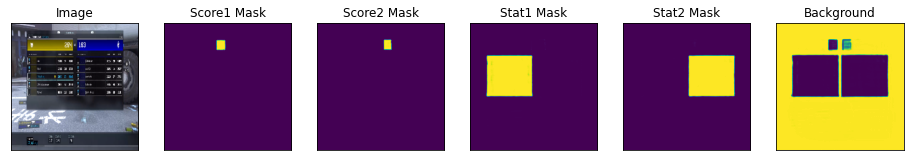

[0.12025031447410583, 0.891142725944519, 24]


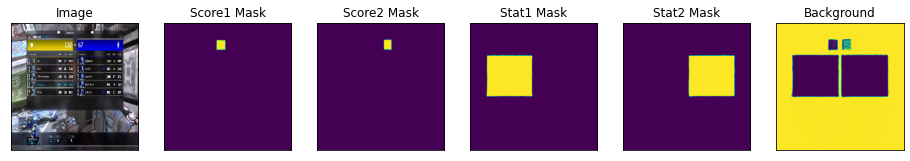

[0.11980000138282776, 0.8896383047103882, 20]


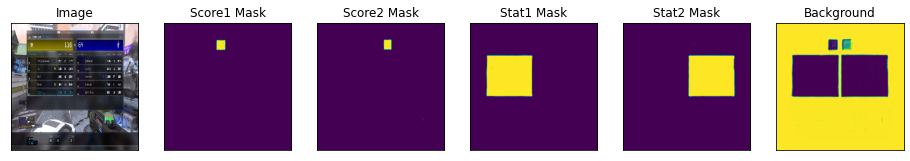

[0.12057963758707047, 0.8890978693962097, 29]


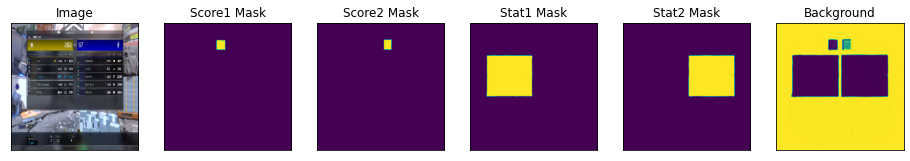

[0.12097371369600296, 0.887969970703125, 14]


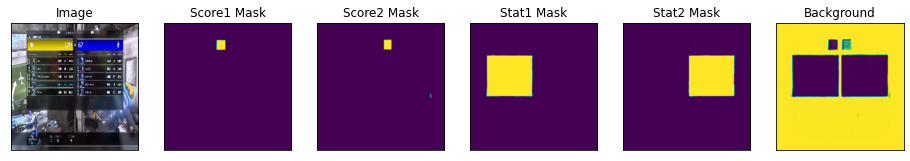

[0.12410733103752136, 0.886318027973175, 18]
TOP-5 Worst:


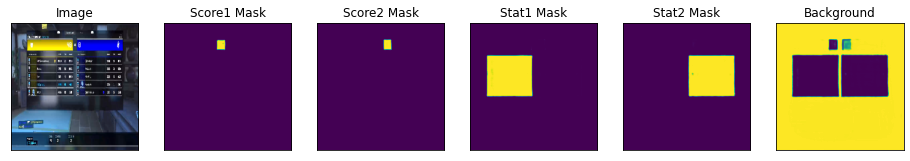

[0.2088659703731537, 0.805141270160675, 17]


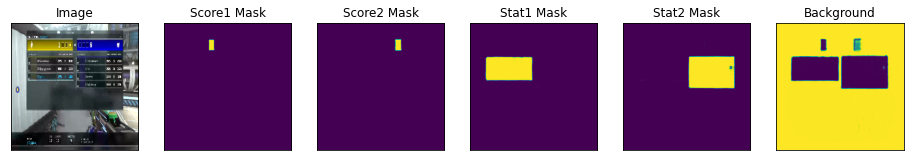

[0.2068551927804947, 0.8045287132263184, 5]


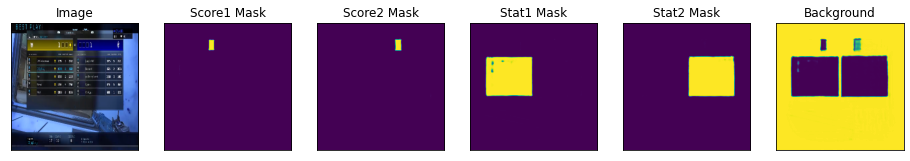

[0.21064609289169312, 0.804469108581543, 28]


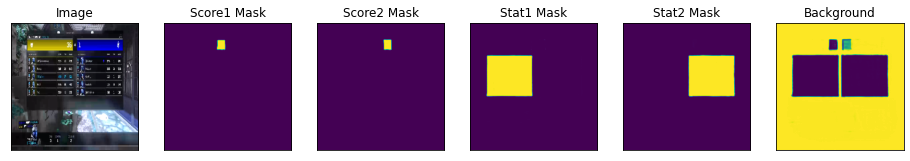

[0.20954851806163788, 0.8040863871574402, 27]


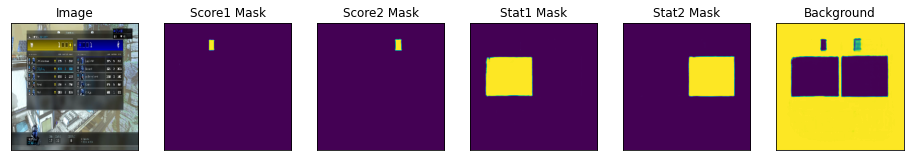

[0.21295630931854248, 0.8019364476203918, 21]


In [ ]:
#Predictions visualisation

best_5 = list(reversed(ind[-5:]))
worst_5 = list(reversed(ind[0:5]))
print("TOP-5 Best:")
for i in best_5:
        visualize(
            image=denormalize(v_images[i].squeeze()),
            score1_mask=preds[i][..., 0],
            score2_mask=preds[i][..., 1],
            stat1_mask=preds[i][..., 2],
            stat2_mask=preds[i][..., 3],
            background=preds[i][..., 4],
        )
        for result in results:
          if result[2] == i:
            print(result)

print("TOP-5 Worst:")

for i in worst_5:
        visualize(
            image=denormalize(v_images[i].squeeze()),
            score1_mask=preds[i][..., 0],
            score2_mask=preds[i][..., 1],
            stat1_mask=preds[i][..., 2],
            stat2_mask=preds[i][..., 3],
            background=preds[i][..., 4],
        )
        for result in results:
          if result[2] == i:
            print(result)


In [ ]:
#Visualisation of cropped segments(disabled)

annFile1 = "src/Screen segmentation/JSONs/valid.json"
annFile2 = "src/Screen segmentation/JSONs/train.json"
image = 0
cocoGt = COCO(annFilee)
imgIds = cocoGt.getImgIds()
fig = plt.figure(figsize=(100, 100))
c = 0
for imgId in imgIds:
  img = cocoGt.loadImgs(imgId)[0]
  for filename in glob.glob(WORKDIR + '/datasets/test/images/imgs/*.png'):
    l_str = list(filename.split("/"))
    if img['file_name'] in l_str:
      image = image_utils.load_img(filename)
      img_array = image_utils.img_to_array(image)
      mask_img = image_utils.array_to_img(y_test[c][..., 1, np.newaxis] > TRESHOLD)
      c = c + 1
      resized_mask = mask_img.resize((img_array.shape[1], img_array.shape[0]))
      resized_mask = image_utils.img_to_array(resized_mask)

      resized_mask = Mask(resized_mask)
      bbox = resized_mask.bbox()
      cropped_image = image_utils.array_to_img(
          img_array[bbox[1]:bbox[3], bbox[0]:bbox[2]])
      #print(cropped_image)
      #plt.subplot(5, 8, c)
      #fig.add_subplot(5, 8, c)
      #plt.xticks([])
      #plt.yticks([])
      #plt.imshow(cropped_image)
      #image_utils.save_img(WORKDIR + '/datasets/tessaract3/test/2_'+img['file_name'], cropped_image)

plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<Figure size 7200x7200 with 0 Axes>